# CSV to DXF converter

This script gets a file produced by the ski scanner, which is a CSV type containing information on displacement and width, and transforms it into a dxf file which is the input for the laser cutting machine used at Pomoca.

## CSV file read


[note] This hardware version relies on 3 rotary encoders (1 for advancement, 2 for width measurement)

Import libraries

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from itertools import groupby
import math 
import scipy.signal
import warnings
import plotly
import cufflinks
import timeit
pd.options.plotting.backend = "plotly"
warnings.simplefilter('ignore')
%matplotlib notebook

Import inputs: insettino geometric data, ski nominal length and csv file from sensors

In [432]:
#Timer in seconds to get processing time
t1 = timeit.default_timer()

# Insettino geometric data
r = 9.719 #cm Arms
dx = 3.35 #cm
dy = 0 #cm
pins_offset2 = 2.917 # cm (distance between 2 pins)/2
pins_offset1 = 2.81
d = 8 #cm distance between two rotary encoders
offsetW1 = r-dx #cm
offsetW2 = r-dx #cm
angle_offset = 12.1
ppcm = 836.5 #249.4

wheels_offset = 8.05# from advancement wheel to arms wheel

ski_nominal_length = 167 #cm
ski_nominal_minwidth = 7.6 #cm
ski_nominal_maxwidth_tip = 11.3 #cm

# Reading raw data (directory\filename.txt)
df = pd.read_csv(r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Tests 09.09.21\PROVA07.TXT', sep = ",")
# Output:
dxf_filename_ski = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\test_ski.dxf'
dxf_filename_skin = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\test_skin.dxf'
dxf_filename_skiandskin = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\test_skiandskin.dxf'
# drop NaN column if any
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop rows with all NaN values if any
df = df.dropna(axis=0, how='all')

r,dx,dy
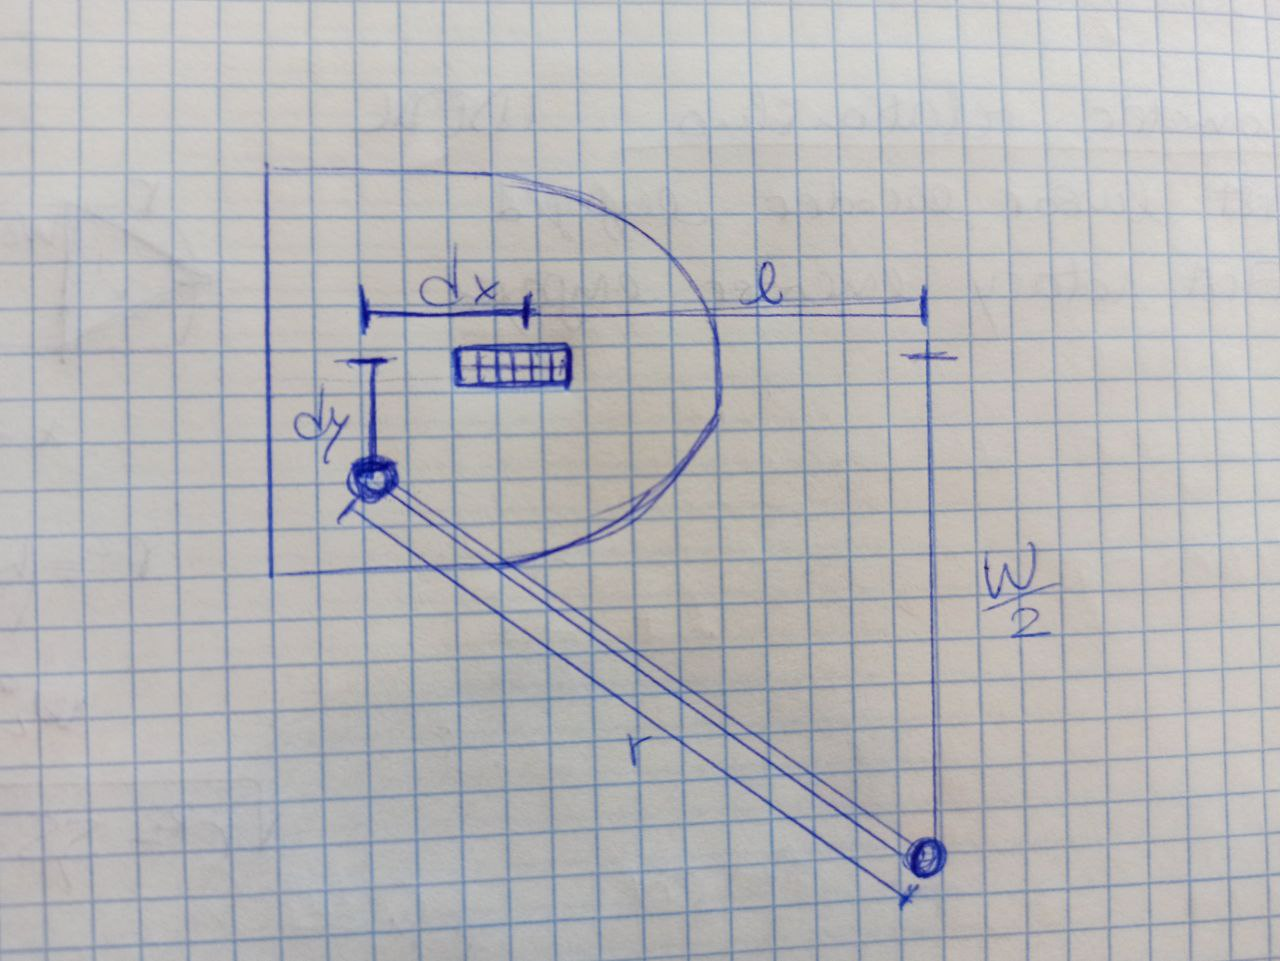

In [433]:
df = df.rename(columns={"W1": "W2", "W2": "W1"})
df

,ID,timestamps,L1,W1,W2
0,1,515436,0,0,3
1,2,515490,0,0,25
2,3,515541,0,0,77
3,4,515592,0,0,139
4,5,515643,0,0,180
...,...,...,...,...,...
446,447,549211,137504,129,4
447,448,549263,137504,99,4
448,449,549315,137504,71,4
449,450,549366,137504,36,4


# From pulses to angle conversions

In [434]:
# W1: linear sensor adapted
ppr1 = 8192
#df['W1'] = -df['W1'] # Change sign if needed according to HW configuration
df['W1'] = df['W1']*360/ppr1 # pulses to degrees conversion
df['W1'] = df['W1']+angle_offset # half width to plot ski profile
#fig = df[['W1']].plot()
#fig.show()

# W2: rotary sensor 
ppr2 = 8192 
#df['W2'] = -df['W2'] # Change sign if needed according to HW configuration
df['W2'] = df['W2']*360/ppr2 # pulses to degrees conversion
df['W2'] = df['W2']+angle_offset # adding offset angle from horizontal direction
#fig = df[['W2']].plot()
#fig.show()

# L1: rotary sensor for advancement
dpc = 36.76 #37.05 # degrees per centimeter (rot to lin conversion)
#df['L1'] = df['L1'] # Change sign if needed according to HW configuration
df['L1'] = df['L1']*360/ppr2 # pulses to degrees conversion
df['L1'] = df['L1']/dpc # adding offset angle from horizontal direction
df['L2'] = df['L1']

# From angles to width conversion

In [435]:
def degree_to_width(df):
    width = r*np.sin(df)
    return width

df['W2'] = degree_to_width(np.radians(df['W2'])) # Degree to cm conversion
df['W2'] = (pins_offset2-(math.sin(np.radians(angle_offset))*r))+df['W2'] # Add pins initial offset

df['W1'] = degree_to_width(np.radians(df['W1'])) # Degree to cm conversion
df['W1'] = (pins_offset1-(math.sin(np.radians(angle_offset))*r))+df['W1'] # Add pins initial offset

#fig = df[['W1','W2']].plot()
#fig.show()

#fig = df[['L1']].plot()
#Fig.show()

<IPython.core.display.Javascript object>


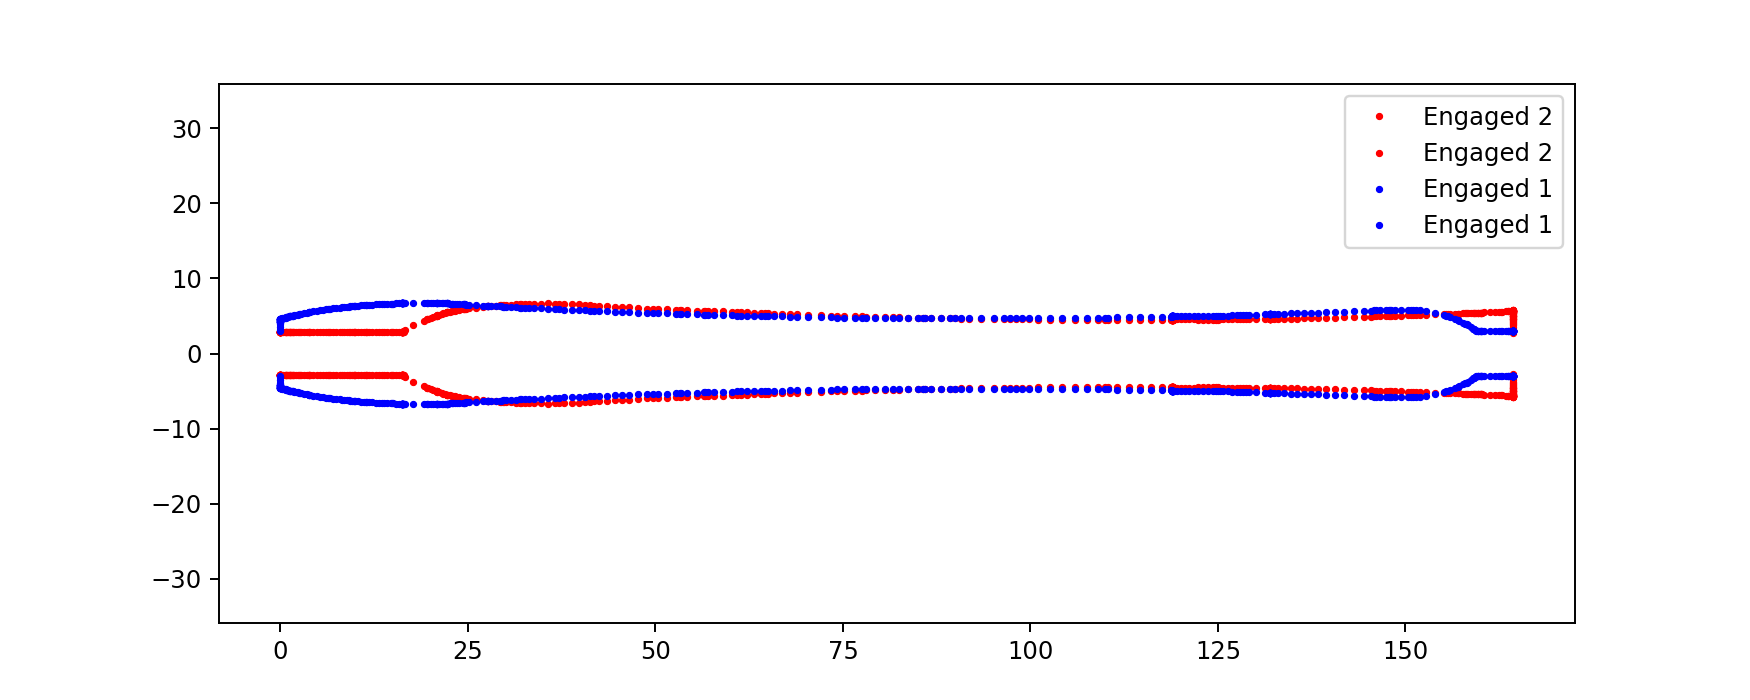

In [436]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

Definition of functions needed to align the measures of lengths and widths

In [437]:
def offset_forward(frame_l,frame_w):
    offset = (np.sqrt(r**2 - (frame_w-dy)**2))-dx
    l_transformed = frame_l + offset
    return l_transformed
def offset_backward(frame_l,frame_w):
    offset = (np.sqrt(r**2 - (frame_w-dy)**2))-dx
    l_transformed = frame_l - offset
    return l_transformed

Definition of function to compute difference of variances of consecutive windows 

In [438]:
def var_differences(df,window_length):
    previous_window_var = pd.DataFrame()
    differences = pd.DataFrame()
    for window in df.rolling(window=window_length):
        #if window.size<window_length:
            #print(window.size)
            #continue
        curr_window_var = window.var()
        diff = previous_window_var - curr_window_var
        differences = differences.append(diff, ignore_index=True)
        previous_window_var = curr_window_var
        #print(window)
        #print(variance)
    differences = differences.dropna(axis=0, how='all')
    return differences

# Identification of engagement 

Identification of engagement of the first couple of sensors (L1 + W1, RED)

<IPython.core.display.Javascript object>


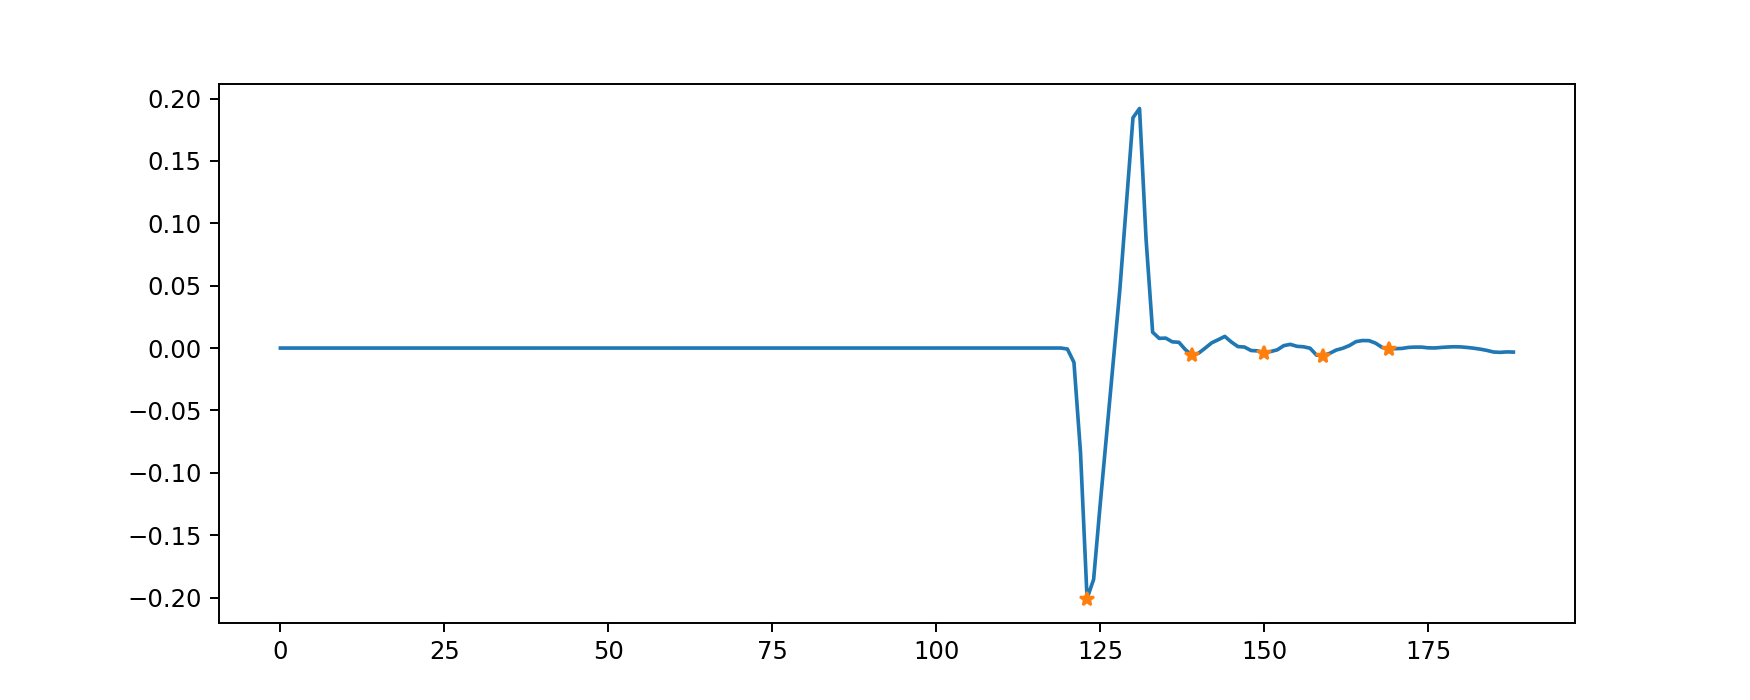

In [439]:
#Selection of interval of points where the engagement should be
epsilon = 30 #cm #acceptable error 
starting_interval = df[['L1','W1']][df['L1']<offsetW1+wheels_offset+epsilon]

#Selection of engagement starting point (start_L1): when W1 starts changing
df1 = pd.DataFrame({'W1':starting_interval['W1']})
window_length = 10
differences = var_differences(df1, window_length) #compute differences of variances of consecutive windows 
array_differences = differences.to_numpy()[:,0] #convert to numpy array to use find_peaks(1D array)

peaks, _ = scipy.signal.find_peaks(-array_differences,prominence=0.001) #find negative peaks because I have var_win1<var_win2

## plot differences and peaks
plt.figure(figsize=(10, 4))
plt.plot(array_differences)
plt.plot(peaks,array_differences[peaks],'*')
plt.show()

#the first peak is the first change in W1 so the engagement moment
start_L1 = peaks[0]
start_L1_value = df1.iloc[peaks[0]].to_numpy()[0]

#select L1 and W1 from the engagement moment to the end
df[['L1','W1']] = df[['L1','W1']][start_L1:]
    

<IPython.core.display.Javascript object>


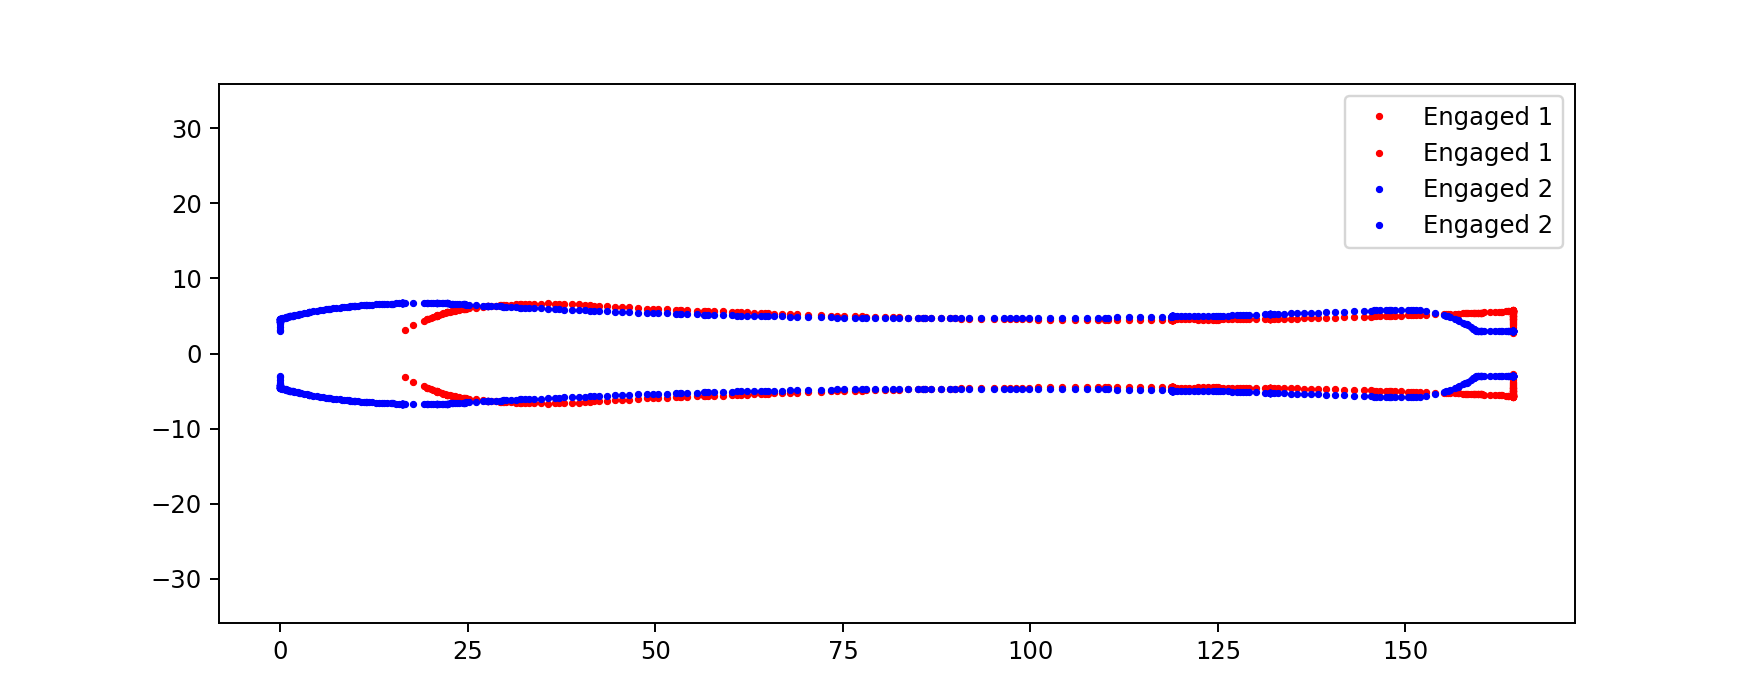

In [440]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 1', 'Engaged 1', 'Engaged 2', 'Engaged 2'])
plt.axis('equal')
plt.show()

Identification of engagement of the second couple of sensors (L2 + W2, BLUE)

<IPython.core.display.Javascript object>


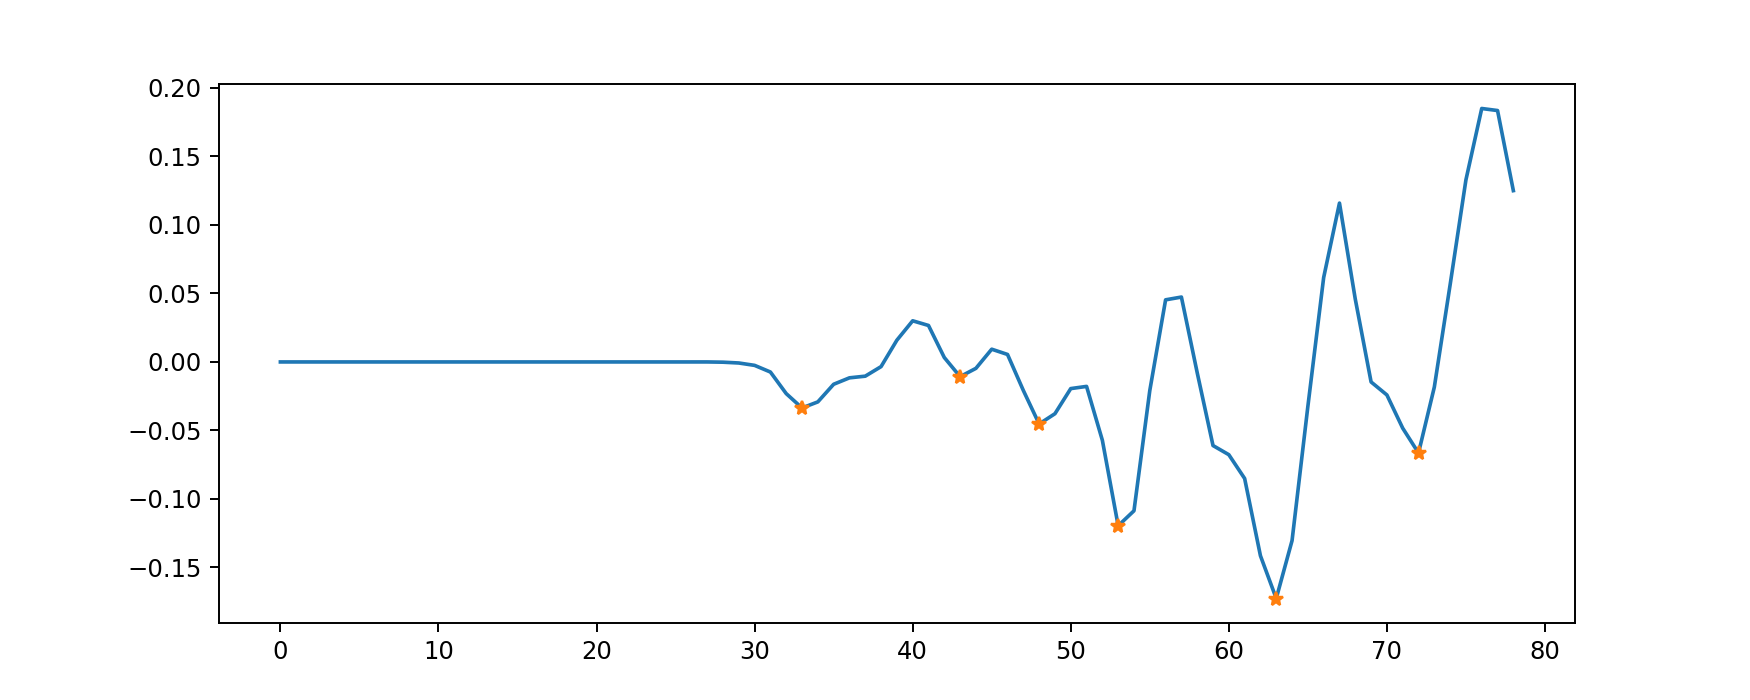

In [441]:
#Selection of interval of points where the engagement should be
epsilon = 10 #cm #acceptable error
starting_interval = df[['L2','W2']][df['L2']<epsilon]

#Selection of engagement starting point (start_L2): when L2 starts changing
df2 = pd.DataFrame({'L2':starting_interval['L2']})
window_length = 10
differences = var_differences(df2,window_length) #compute differences of variances of consecutive windows
array_differences = differences.to_numpy()[:,0] #convert to numpy array to use find_peaks(1D array)

peaks, _ = scipy.signal.find_peaks(-array_differences,prominence=0.01) #find negative peaks because I have var_win1<var_win2

## plot differences and peaks
plt.figure(figsize=(10, 4))
plt.plot(array_differences)
plt.plot(peaks,array_differences[peaks],'*')
plt.show()

#the first peak is the first change in W1 so the engagement moment
start_L2 = peaks[0]
start_L2_value = df2.iloc[peaks[0]].to_numpy()[0]

#select L1 and W1 from the engagement moment to the end
df[['L2','W2']] = df[['L2','W2']][start_L2:]

Rephasing of W2 and L2 data

In [442]:
#Reset offset of Length2 that might have been accidentally accumulated before the engagement 
df['L2'] = df['L2'] - df['L2'].iloc[start_L2]

#Add geometrical offset
df['L2'] = offset_forward(df['L2'],df['W2'])

#Visualise the very first starting data
#df[['L2','W2']].dropna(axis=0, how='all')

Rephasing of W1 and L1 data

In [443]:
# Subtract geometrical offset
df['L1'] = offset_backward(df['L1'],df['W1']) - wheels_offset

# Reset offset of Length1 that might have been accidentally accumulated before the engagement
df['L1'] = df['L1'] - df['L1'].iloc[start_L1]

# Visualise the very first starting data
#df[['L1','W1']].dropna(axis=0, how='all')

Plot two sides of the ski with tip data fixed

<IPython.core.display.Javascript object>


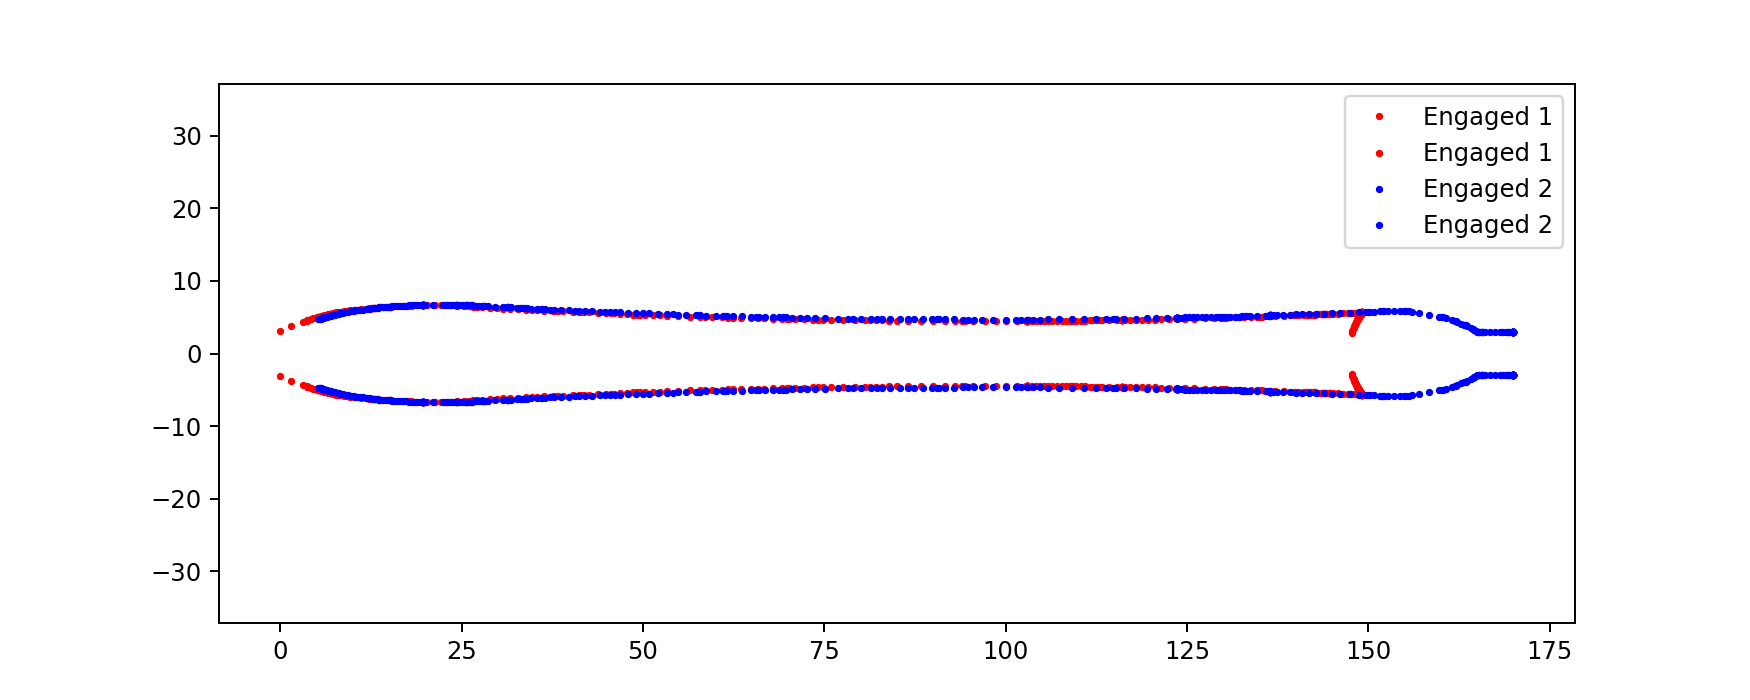

In [444]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 1', 'Engaged 1', 'Engaged 2', 'Engaged 2'])
plt.axis('equal')
plt.show()

# Identification of disengagement 

Identification of disengagement of the first couple of sensors (L + W, RED) 

In [445]:
#Selection of interval of points where the disengagement should be
epsilon = 40 #cm #acceptable error
starting_interval = df[['L1','W1']][df['L1']>(ski_nominal_length-epsilon)]

#Selection of disengagement ending point (end_L1): when L1 stops changing
df3 = pd.DataFrame({'L1':starting_interval['L1']})
window_length = 10
differences = var_differences(df3,window_length)
array_differences = differences.to_numpy()[:,0]

peaks, _ = scipy.signal.find_peaks(array_differences,prominence=0.03)

#plt.figure(figsize=(10, 4))
#plt.plot(array_differences)
#plt.plot(peaks,array_differences[peaks],'*')
#plt.show()

end_L1 = peaks[-1] #the last peak is the last change in L1
end_L1_value = df3.iloc[end_L1].to_numpy()[0]
overall_end_L1 = (df[['L1','W1']][(df['L1'] == starting_interval['L1'].iloc[end_L1]) & (df['W1'] == starting_interval['W1'].iloc[end_L1])].index).tolist()[0]

#Keep values till the last peak
df[['L1','W1']] = df[['L1','W1']][:overall_end_L1]

<IPython.core.display.Javascript object>


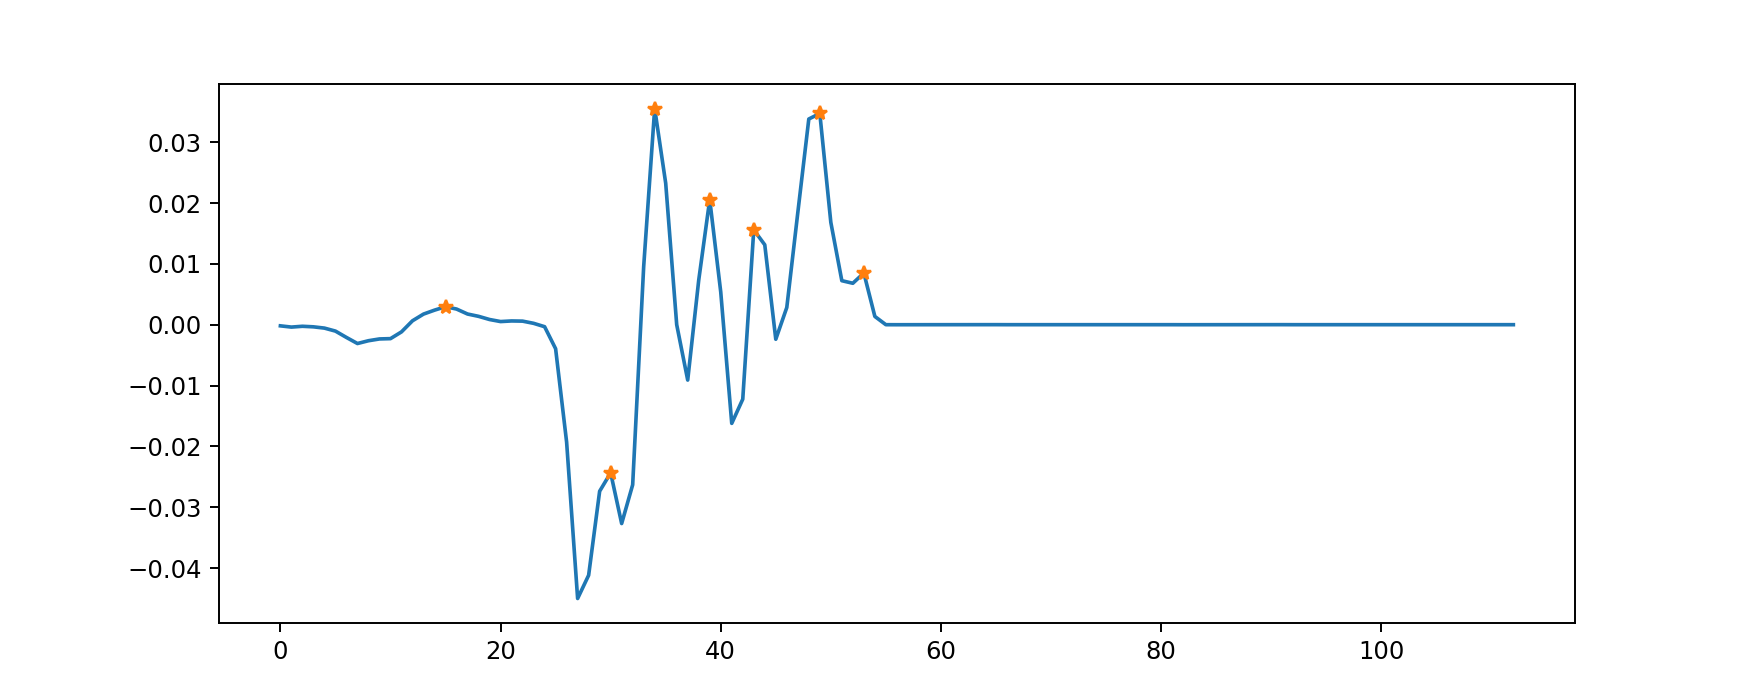

In [446]:
#Selection of interval of points where the disengagement should be
epsilon = 30 #cm #acceptable error
starting_interval = df[['L2','W2']][df['L2']>(ski_nominal_length-epsilon)]

#Selection of disengagement ending point (end_L2): when W2 stops changing
df4 = pd.DataFrame({'W2':starting_interval['W2']})
window_length = 10
differences = var_differences(df4,window_length)
array_differences = differences.to_numpy()[:,0]

peaks, _ = scipy.signal.find_peaks(array_differences,prominence=0.001)

plt.figure(figsize=(10, 4))
plt.plot(array_differences)
plt.plot(peaks,array_differences[peaks],'*')
plt.show()

#print(df4.iloc[peaks].to_numpy())
end_L2 = peaks[np.argmax(array_differences[peaks])] #the last peak is the last change in W2
end_L2_value = df4.iloc[end_L2].to_numpy()[0]

overall_end_L2 = (df[['L2','W2']][(df['L2'] == starting_interval['L2'].iloc[end_L2]) & (df['W2'] == starting_interval['W2'].iloc[end_L2])].index).tolist()[0]

#Keep values till the last peak
df[['L2','W2']] = df[['L2','W2']][:overall_end_L2]

<IPython.core.display.Javascript object>


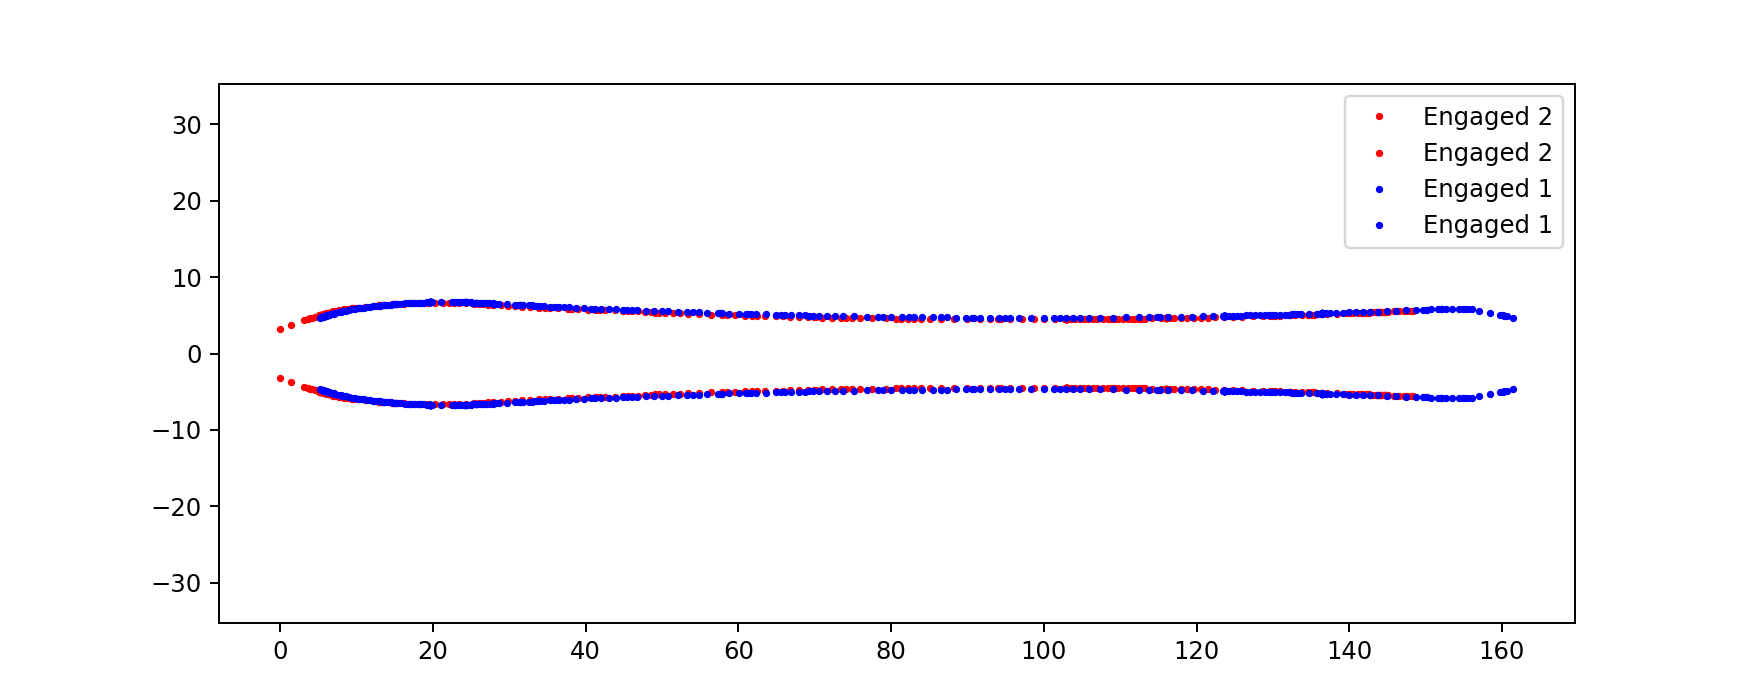

In [447]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()


In [448]:
# Drop rows with all NaN values
df = df.dropna(axis=0, how='all')
# Drop some blue values
df[['L2','W2']] = df[['L2','W2']][100:]

# Merging data from 2 couples of sensors data in one single ski profile

In this section an approach of mean computation of the nearest points is implemented:
For each point coming from one couple of sensors an interval of the closest points from the other couple of sensors is selected, the euclidean distance from each point of the interval is computed and the nearest is select for the mean computation. 

In [449]:
t2 = timeit.default_timer()

In [450]:
# New processing
# Start iterating the secondly engaged sensors: when I get closed to firstly engaged sensor I start mediating
start_L2 = df['L2'].min() #After all sensors are engaged the merging should begin (Start_L2 represents the starting moment)
delta = 5 #Maximum distance from the current point included in the interval of the closest points

ski_profile = pd.DataFrame(columns=['W','L'])

df_temp = pd.DataFrame(df[['W1','L1']][df['L1']<start_L2])
df_temp = df_temp.rename(columns={"W1": "W", "L1": "L"})
ski_profile = ski_profile.append(df_temp)

df_1 = df[['W1','L1']][df['L1'] >= start_L2]
df_2 = df[['W2','L2']][(df['L2'] >= start_L2) & (df['L2'] <= df_1['L1'].iloc[-1])]
#print(df_1['L1'].iloc[-1])

df_1 = df_1.rename(columns={"W1": "W", "L1": "L"})
df_2 = df_2.rename(columns={"W2": "W", "L2": "L"})

#print(df_1)
#print(df_2)

pd_merged = pd.concat([df_1, df_2])
pd_merged = pd_merged.sort_values(['L'])

#print(pd_merged)

pd_merged_2 = pd_merged.shift(periods=1)

#print(pd_merged_2)

mean_l = pd.concat([pd_merged['L'],pd_merged_2['L']], axis=1).mean(axis=1)
#print(pd.concat([pd_merged['L'],pd_merged_2['L']], axis=1))
#print(mean_l)

mean_w = pd.concat([pd_merged['W'],pd_merged_2['W']], axis=1).mean(axis=1)
#print(pd.concat([pd_merged['W'],pd_merged_2['W']], axis=1))
#print(mean_w)

mean = pd.concat([mean_w, mean_l], axis=1)
mean = mean.rename(columns={0: "W", 1: "L"})
#print(mean)

ski_profile = ski_profile.append(mean)
#print(ski_profile)

In [451]:
#mean_points_W, mean_points_L = zip(*df_temp.apply(merge, axis = 1))
#mean_points = pd.DataFrame(data = {'W':mean_points_W, 'L':mean_points_L})
#print(mean_points)
#ski_profile = ski_profile.append(mean_points)

In [452]:
# At the end no merging is needed: save all data points in ski profile
# Add tail to ski profile
tail = df[['W2','L2']][df['L2']> df['L1'].dropna(axis=0, how='all').iloc[-1]]
tail = tail.rename(columns={"W2": "W", "L2": "L"})
ski_profile = ski_profile.append(tail)

In [453]:
t3 = timeit.default_timer()

<IPython.core.display.Javascript object>


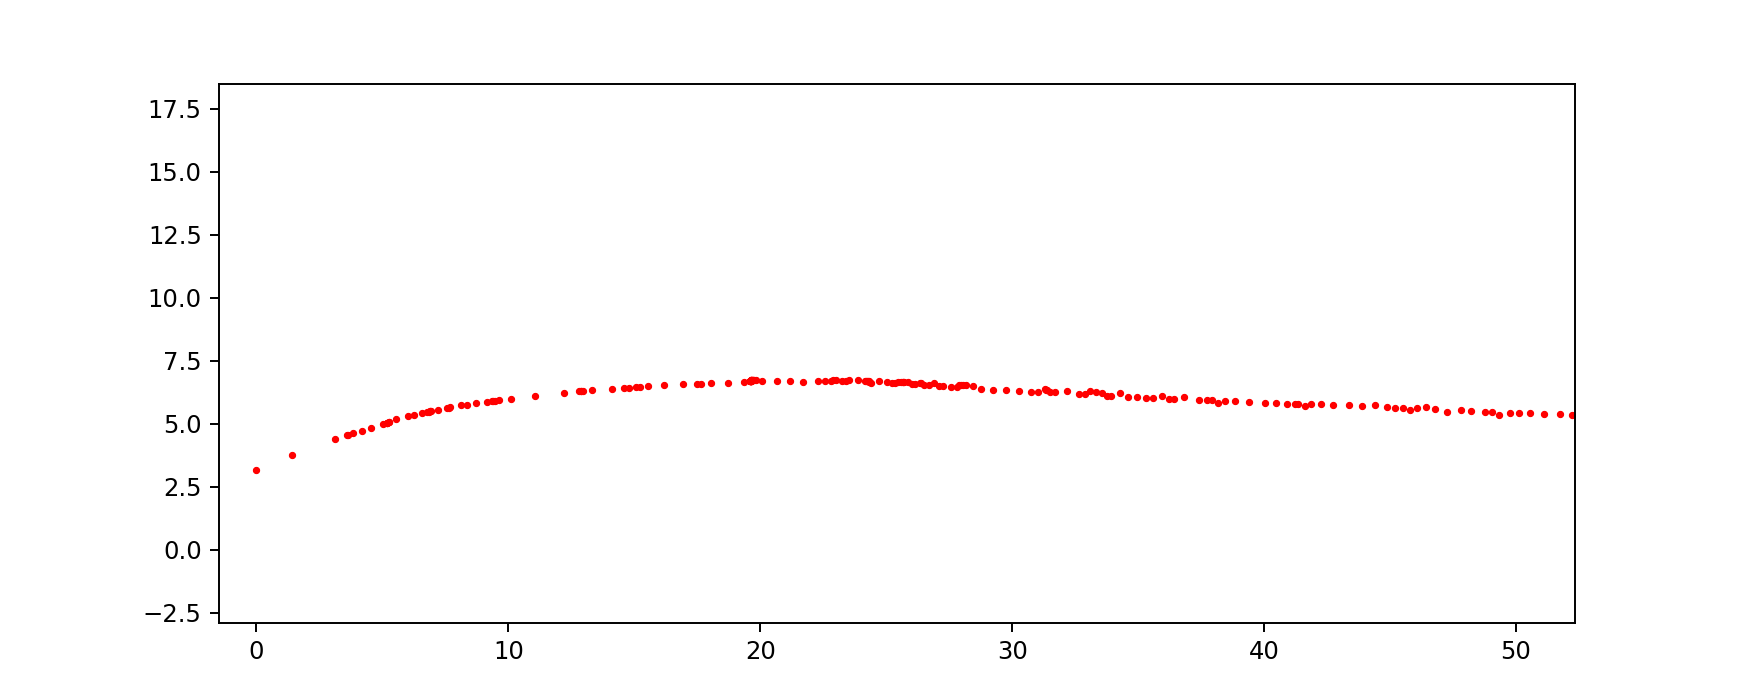

In [454]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(ski_profile['L'], ski_profile['W'], 'ro', markersize = 2)
plt.plot(ski_profile['L'], -ski_profile['W'], 'ro', markersize = 2)

plt.axis('equal')
plt.show()

# Spline generation and saving in dxf file

Division of data in sections (from 0 to 14% of length for tip section, from 94% of length to end for tail section) and spline generation

Define function to find the closest point of a dataframe array to a point

<IPython.core.display.Javascript object>


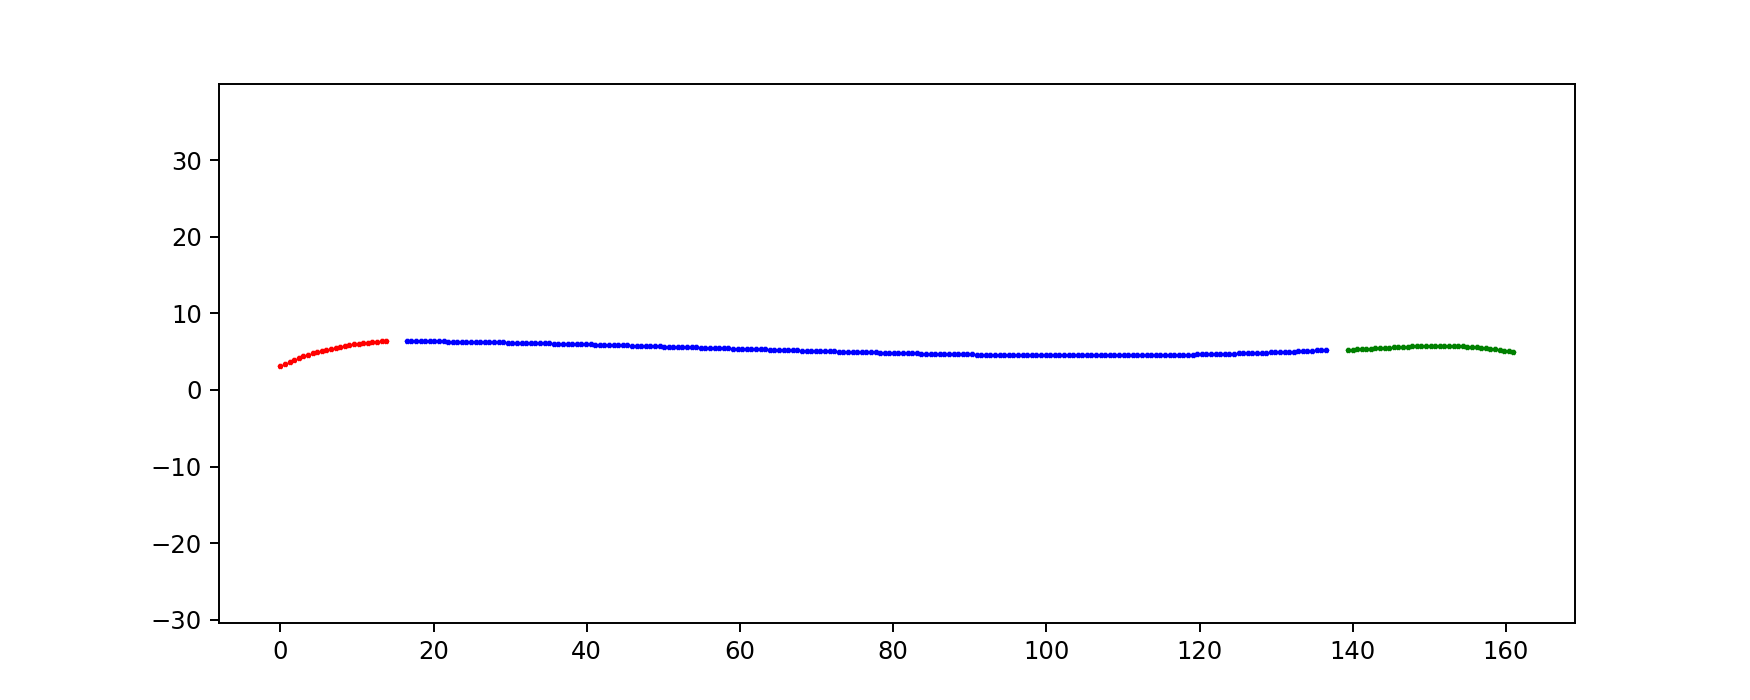

7.6
11.3
10.1


In [465]:
def find_closest_point(point, df_input):
        delta = 10
        close_interval = df_input[abs(df_input-point) < delta]
        diff_interval = abs(close_interval - point)
        sorted_diff = diff_interval.sort_values()
        index = sorted_diff.first_valid_index()
        closest_point = df_input.loc[index]
        if (str(type(closest_point)) == "<class 'pandas.core.series.Series'>"):
            closest_point = closest_point.to_numpy()[0]
        return closest_point

ski_profile = ski_profile.sort_values('L',ascending=True)
max_length = ski_profile['L'].max()

# Find the closest points to the 14 and 94 percent of the length in order to construct 3 different splines (otherwise it cannot fit points really well)
start_section1 = find_closest_point(0*max_length,ski_profile['L'])
end_section1 = find_closest_point(0.2*max_length,ski_profile['L'])

start_section2 = end_section1
end_section2 = find_closest_point(0.99*max_length,ski_profile['L'])

start_section3 = end_section2
end_section3 = max_length

# Generation of splines for control points smoothing and plot

dx = 0.6

# Create mysplines in order to smooth data for drawing the actual splines in dxf
extra = 8
offset_start_points_section2 = 4
offset_end_points_section2 = 4

section1 = ski_profile[['L','W']][ (ski_profile['L']>=start_section1-extra) & (ski_profile['L']<=end_section1+extra)]
section2 = ski_profile[['L','W']][ (ski_profile['L']>=start_section2-extra) & (ski_profile['L']<=end_section2+extra)]

#section1 = section1[:-10]
#section1 = section1.append(section2.iloc[[1]])

myspline1 = scipy.interpolate.UnivariateSpline(section1['L'].to_numpy(), section1['W'].to_numpy())
x1 = np.arange(start_section1, end_section1, dx)
y_myspline1 = myspline1(x1)

plt.figure(figsize=(10, 4))
plt.plot(x1[:], y_myspline1[:], 'r*', markersize = 2)
#plt.plot(section1['L'], section1['W'], 'r*', markersize=2)
#plt.plot(section1['L'], section1['W'], 'r*', markersize=2)

myspline2 = scipy.interpolate.UnivariateSpline(section2['L'].to_numpy(), section2['W'].to_numpy())
x2 = np.arange(start_section2, end_section2, dx)
y_myspline2 = myspline2(x2)
plt.plot(x2[offset_start_points_section2:-offset_end_points_section2], y_myspline2[offset_start_points_section2:-offset_end_points_section2], 'b*', markersize = 2)
#plt.plot(section2['L'], section2['W'], 'b*', markersize=2)

section3 = ski_profile[['L','W']][ (ski_profile['L']>=start_section3-extra) & (ski_profile['L']<=end_section3+extra)]
myspline3 = scipy.interpolate.UnivariateSpline(section3['L'].to_numpy(), section3['W'].to_numpy())
x3 = np.arange(start_section3, end_section3, dx)
y_myspline3 = myspline3(x3)
plt.plot(x3[:], y_myspline3[:], 'g*', markersize = 2)
#plt.plot(section3['L'], section3['W'], 'g*', markersize=2)

plt.axis('equal')
plt.show()

sectionA = []
sectionB = []

section1 = np.concatenate([x1[:,np.newaxis],y_myspline1[:,np.newaxis]],axis = 1)
sectionA = np.vstack([section1])

section2 = np.concatenate([x2[offset_start_points_section2:-offset_end_points_section2,np.newaxis],y_myspline2[offset_start_points_section2:-offset_end_points_section2,np.newaxis]],axis = 1)
sectionA = np.vstack([sectionA,section2])

section3 = np.concatenate([x3[:,np.newaxis],y_myspline3[:,np.newaxis]],axis = 1)
sectionA = np.vstack([sectionA,section3])

section4 = np.concatenate([x1[:,np.newaxis],-y_myspline1[:,np.newaxis]],axis = 1)
sectionB = np.vstack([section4])

section5 = np.concatenate([x2[offset_start_points_section2:-offset_end_points_section2,np.newaxis],-y_myspline2[offset_start_points_section2:-offset_end_points_section2,np.newaxis]],axis = 1)
sectionB = np.vstack([sectionB,section5])

section6 = np.concatenate([x3[:,np.newaxis],-y_myspline3[:,np.newaxis]],axis = 1)
sectionB = np.vstack([sectionB,section6])

# Rescaling data with nominal information

def length_adj(array,nominal_length):
    maximum = np.amax(array)
    array = (array/maximum)*nominal_length
    return array
def width_adj(array,nominal_minwidth,nominal_maxwidth):
    minimum = np.amin(array[40:-40])
    maximum = np.amax(array[0:(round(len(array)/2))])
    array = (((array-minimum)/(maximum-minimum))*(nominal_maxwidth-nominal_minwidth))+nominal_minwidth
    return array

#Rescaling with nominal information
sectionA[:,0] = length_adj(sectionA[:,0],ski_nominal_length)
sectionA[:,1] = width_adj(sectionA[:,1],(ski_nominal_minwidth)/2,(ski_nominal_maxwidth_tip/2))

sectionB[:,0] = length_adj(sectionB[:,0],ski_nominal_length)
sectionB[:,1] = -(width_adj(sectionA[:,1],(ski_nominal_minwidth)/2,(ski_nominal_maxwidth_tip/2)))

max_length = np.amax(sectionA[:,0])
max_width_tip = np.amax(sectionA[0:(round(len(sectionA[:,1])/2)),1])
max_width_tail = np.amax(sectionA[round(len(sectionA[:,1])/2):-1,1])
minimum_width = np.amin(sectionA[40:-40,1])

minimum_width = round(minimum_width*2,1)
max_width_tip = round(max_width_tip*2,1)
max_width_tail = round(max_width_tail*2,1)

print(minimum_width)
print(max_width_tip)
print(max_width_tail)


## Skin profile computation

In [456]:
#Setting parameters for skin drawing 

dist_from_tail = 6 #cm
dist_from_tip = 6 #cm
dist_from_side = 0.17 #cm
dist_from_side_tip = 0.9 #cm this is the max distance from the side of the ski in the tip
dist_from_side_tail = 0.9 #cm
delta = 8 #cm needed to include some points of the ski profile to draw a spline (you need more points than the order of the interpolation)

skin_profileA = sectionA[(sectionA[:,0] > dist_from_tip) & (sectionA[:,0] < max_length-dist_from_tail)]
start_spline = skin_profileA[0,:]
start_spline[1] = start_spline[1] - dist_from_side_tip
skin_profileA = sectionA[(sectionA[:,0] > end_section1) & (sectionA[:,0] < max_length-dist_from_tail)]
skin_profileA[:,1] = skin_profileA[:,1] - dist_from_side

skin_profileA = np.vstack([start_spline,skin_profileA])
tip = skin_profileA[skin_profileA[:,0] < (end_section1 + delta)] #select a set of points for spline interpolation
yspline = scipy.interpolate.UnivariateSpline(tip[:,0], tip[:,1])
x = np.arange(tip[0,0], tip[-1,0], dx)
tip_spline = yspline(x) # generate spline for the tip section
final_tip = np.vstack([x,tip_spline]).T
skin_profileA = np.vstack([final_tip,skin_profileA[skin_profileA[:,0] >= (end_section1 + delta)]])

end_spline = skin_profileA[-1,:]
end_spline[1] = end_spline[1] - (dist_from_side_tail+dist_from_side)
start_tail = 0.9*(max_length-dist_from_tail)

tail = skin_profileA[(skin_profileA[:,0]<start_tail) & (skin_profileA[:,0]>(start_tail-delta))]
tail = np.vstack([tail,end_spline])

yspline = scipy.interpolate.UnivariateSpline(tail[:,0], tail[:,1])
x = np.arange(tail[0,0], tail[-1,0], dx)
tail_spline = yspline(x) # generate spline for the tail section
final_tail = np.vstack([x,tail_spline]).T

skin_profileA = np.vstack([skin_profileA[skin_profileA[:,0]<=(start_tail-delta)], final_tail])

skin_profileB = np.copy(skin_profileA)
skin_profileB[:,1] = -skin_profileB[:,1] 



<IPython.core.display.Javascript object>


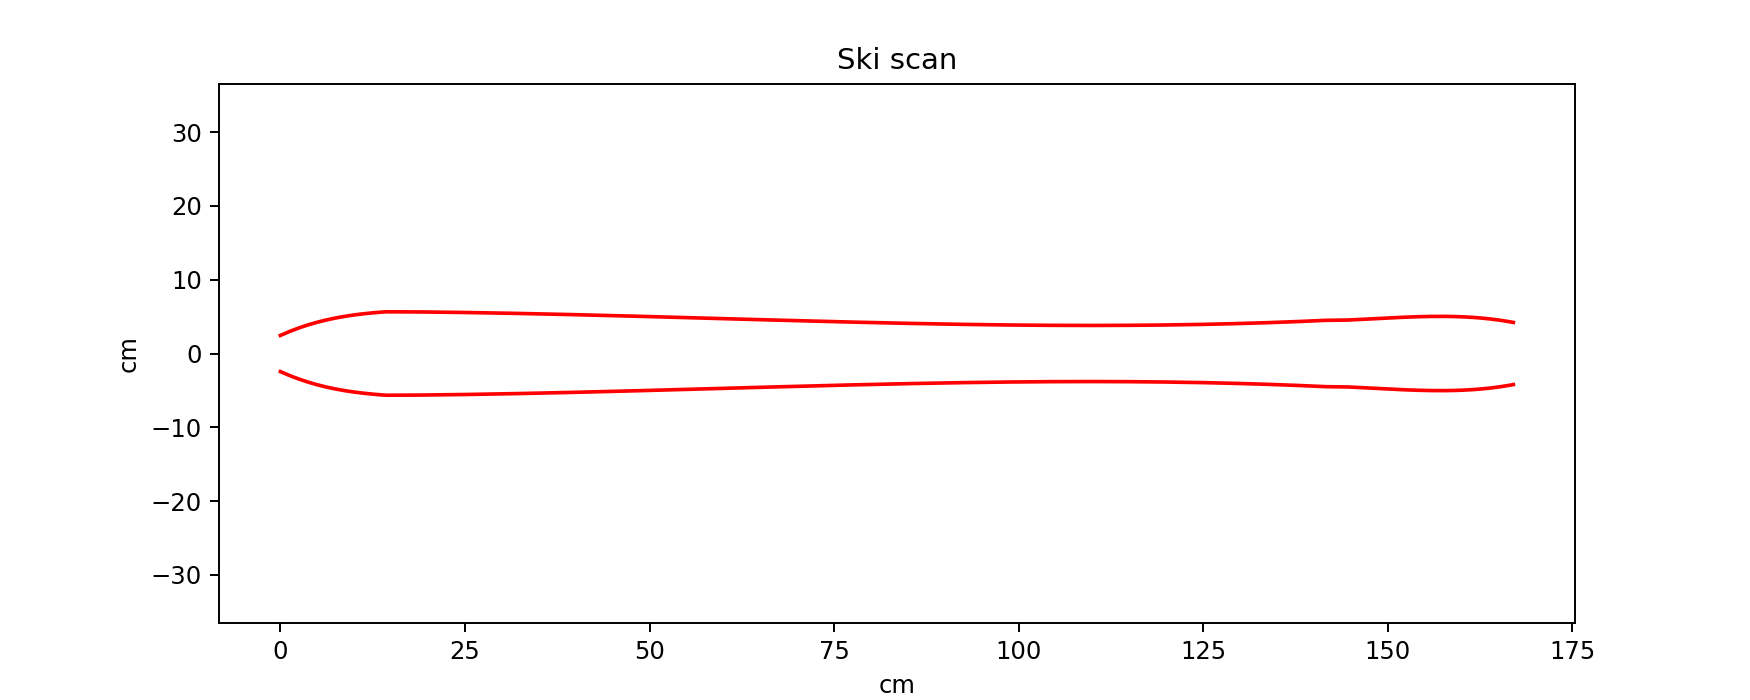

In [457]:
fig1 = plt.figure(figsize=(10, 4))

plt.plot(sectionA[:,0], sectionA[:,1], 'r-', markersize = 2)
plt.plot(sectionB[:,0], sectionB[:,1], 'r-', markersize = 2)
#plt.plot(skin_profileA[:,0], skin_profileA[:,1], 'b-', markersize = 1)
#plt.plot(skin_profileB[:,0], skin_profileB[:,1], 'b-', markersize = 1)
plt.title('Ski scan')
plt.axis('equal')
plt.xlabel('cm')
plt.ylabel('cm')
plt.show()

Add splines and lines to DXF file

In [458]:
# Create a new DXF document
doc = dxf.new(dxfversion='R2018')
doc_ski = dxf.new(dxfversion='R2018')
doc_skin = dxf.new(dxfversion='R2018')

# DXF entities (LINE, TEXT, ...) reside in a layout (like modelspace).
msp = doc.modelspace()
msp_ski = doc_ski.modelspace()
msp_skin = doc_skin.modelspace()

##Add just one single spline with smoothed control points
doc.layers.new(name='Ski')
doc.layers.new(name='Skin')

doc_ski.layers.new(name='Ski')
doc_skin.layers.new(name='Skin')

msp.add_cad_spline_control_frame(fit_points = sectionA, dxfattribs={'layer': 'Ski'})
msp_ski.add_cad_spline_control_frame(fit_points = sectionA, dxfattribs={'layer': 'Ski'})
minimum = np.amin(sectionA[40:-40,1])
maximum = np.amax(sectionA[:,0])
maximum_width = np.amax(sectionA[:,1])

msp.add_cad_spline_control_frame(fit_points = sectionB, dxfattribs={'layer': 'Ski'})
msp_ski.add_cad_spline_control_frame(fit_points = sectionB, dxfattribs={'layer': 'Ski'})

msp.add_line((sectionA[0,0],sectionA[0,1]), (sectionB[0,0],sectionB[0,1]), dxfattribs={'layer': 'Ski'})
msp.add_line((sectionA[-1,0],sectionA[-1,1]), (sectionB[-1,0],sectionB[-1,1]), dxfattribs={'layer': 'Ski'})

msp_ski.add_line((sectionA[0,0],sectionA[0,1]), (sectionB[0,0],sectionB[0,1]), dxfattribs={'layer': 'Ski'})
msp_ski.add_line((sectionA[-1,0],sectionA[-1,1]), (sectionB[-1,0],sectionB[-1,1]), dxfattribs={'layer': 'Ski'})

##Add skin_profile splines
msp.add_cad_spline_control_frame(fit_points = skin_profileA, dxfattribs={'layer': 'Skin'})
msp.add_cad_spline_control_frame(fit_points = skin_profileB, dxfattribs={'layer': 'Skin'})
msp.add_line((skin_profileA[0,0],skin_profileA[0,1]),(skin_profileB[0,0],skin_profileB[0,1]), dxfattribs={'layer': 'Skin'})
msp.add_line((skin_profileA[-1,0],skin_profileA[-1,1]),(skin_profileB[-1,0],skin_profileB[-1,1]), dxfattribs={'layer': 'Skin'})

msp_skin.add_cad_spline_control_frame(fit_points = skin_profileA, dxfattribs={'layer': 'Skin'})
msp_skin.add_cad_spline_control_frame(fit_points = skin_profileB, dxfattribs={'layer': 'Skin'})
msp_skin.add_line((skin_profileA[0,0],skin_profileA[0,1]),(skin_profileB[0,0],skin_profileB[0,1]), dxfattribs={'layer': 'Skin'})
msp_skin.add_line((skin_profileA[-1,0],skin_profileA[-1,1]),(skin_profileB[-1,0],skin_profileB[-1,1]), dxfattribs={'layer': 'Skin'})

# Save DXF document.
doc.saveas(dxf_filename_skiandskin)
doc_ski.saveas(dxf_filename_ski)
doc_skin.saveas(dxf_filename_skin)

t4 = timeit.default_timer()

Visualisation of dxf file

<IPython.core.display.Javascript object>


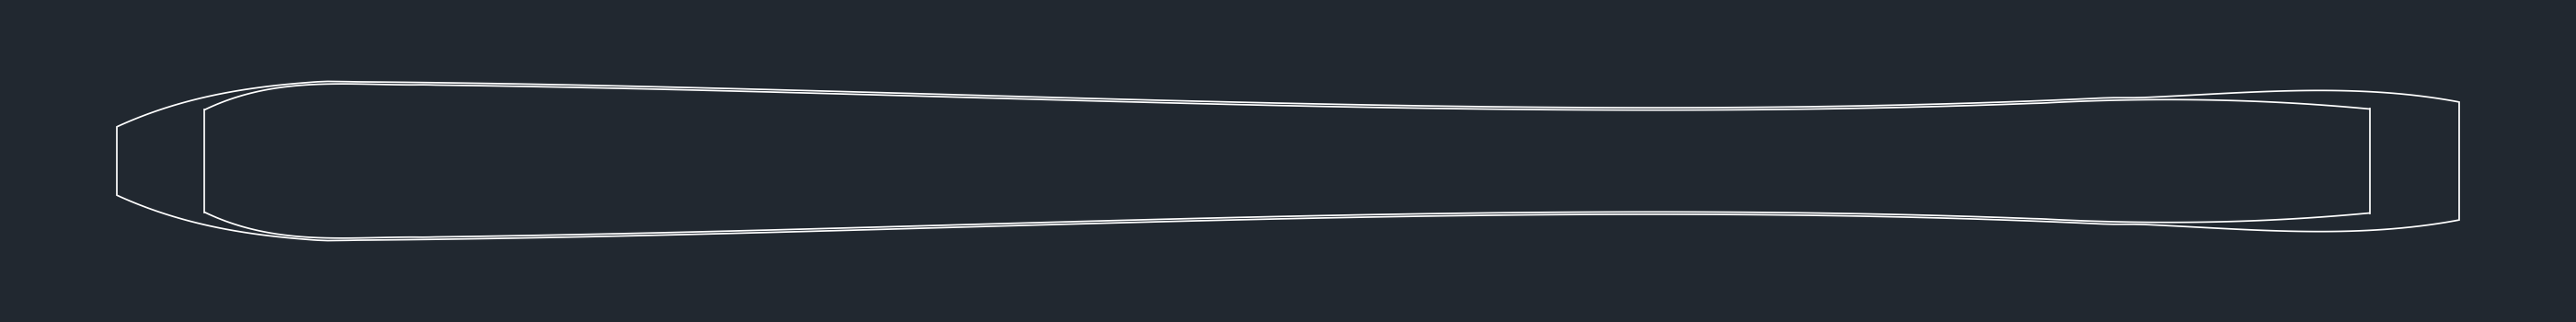

In [459]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile(dxf_filename_skiandskin)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

In [460]:
tend = timeit.default_timer()

In [461]:
init_time = t2-t1
merging_time = t3-t2
dxf_gen_time = t4-t3
tot_time = tend-t1
print(init_time)
print(merging_time)
print(dxf_gen_time)
print(tot_time)

1.620568700000149
0.08704610000040702
0.5266795999996248
2.357290300000386
